In [1]:
import requests
import json
import sys
import os
import io
from PIL import Image, ImageFilter
from google.cloud import storage
from io import BytesIO
import time
import threading
import ipfsApi
import random
import nft_storage
import time
import nft_storage
from pprint import pprint
from nft_storage.api import nft_storage_api
from nft_storage.model.check_response import CheckResponse
from nft_storage.model.delete_response import DeleteResponse
from nft_storage.model.error_response import ErrorResponse
from nft_storage.model.forbidden_error_response import ForbiddenErrorResponse
from nft_storage.model.get_response import GetResponse
from nft_storage.model.list_response import ListResponse
from nft_storage.model.unauthorized_error_response import UnauthorizedErrorResponse
from nft_storage.model.upload_response import UploadResponse
# Defining the host is optional and defaults to https://api.nft.storage
# See configuration.py for a list of all supported configuration parameters.

In [2]:
import yaml

# Load the YAML file
with open('../aws/lambda/.env.yaml', 'r') as file:
    env_vars = yaml.safe_load(file)

# Retrieve the values of SDAPI_KEY and CLIPDROP_KEY
SDAPI_KEY = env_vars.get('SDAPI_KEY')
CLIPDROP_KEY = env_vars.get('CLIPDROP_KEY')
NFTSTORAGE_KEY = env_vars.get('NFTSTORAGE_KEY')

{
    "status": "success",
    "generationTime": 12.04,
    "id": 88813118,
    "output": [
        "https://pub-3626123a908346a7a8be8d9295f44e26.r2.dev/generations/0-efd74d12-0c8a-417e-a4cd-e3cbffab0531.png"
    ],
    "meta": {
        "prompt": " a predator alien wearing a Roman Gladiator helmet with this shape",
        "model_id": "juggernaut111",
        "controlnet_model": "canny",
        "controlnet_type": "canny",
        "negative_prompt": "",
        "scheduler": "UniPCMultistepScheduler",
        "safety_checker": "no",
        "auto_hint": "yes",
        "guess_mode": "no",
        "strength": 1,
        "W": 1024,
        "H": 1024,
        "guidance_scale": 7.5,
        "controlnet_conditioning_scale": 1,
        "seed": 1239782784,
        "multi_lingual": "no",
        "use_karras_sigmas": "yes",
        "algorithm_type": "no",
        "safety_checker_type": "sensitive_content_text",
        "instant_response": "no",
        "tomesd": "yes",
        "init_image": "htt

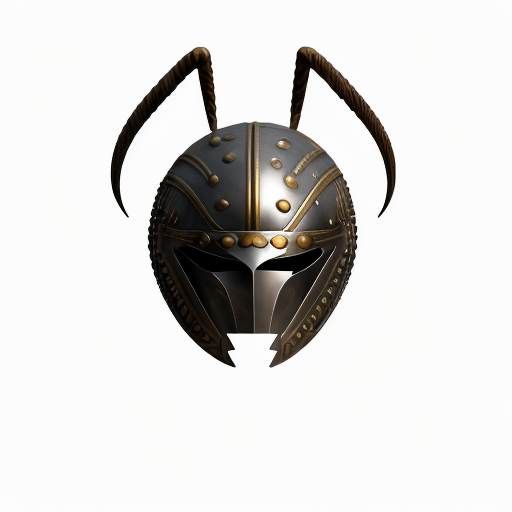

In [3]:
url = "https://stablediffusionapi.com/api/v5/controlnet"

payload = json.dumps({
  "key": SDAPI_KEY,
  "controlnet_model": "canny",
  "controlnet_type": "canny",
  "model_id": "juggernaut111",
  "auto_hint": "yes",
  "guess_mode": "no",
  "prompt": "a predator alien wearing a Roman Gladiator helmet with this shape",
  "negative_prompt": None,
  "init_image": "https://s3.amazonaws.com/esov-sdapi-args-images/sp_512.jpg",
#   "init_image": "https://s3.amazonaws.com/esov-sdapi-args-images/sp_512.jpg",
  # "init_image": "https://s3.amazonaws.com/esov-sdapi-args-images/final_sp.png",
  # "control_image": "https://s3.amazonaws.com/esov-sdapi-args-images/original_sp.jpg",
  # "mask_image": "https://s3.amazonaws.com/esov-sdapi-args-images/original_sp.jpg",
  "width": "1024",
  "height": "1024",
  "samples": "1",
  "upscale": "yes",
  "scheduler": "UniPCMultistepScheduler",
  "num_inference_steps": "35",
  "safety_checker": "no",
  "enhance_prompt": "yes",
  "guidance_scale": 7.5,
  "strength": 0.55,
  "lora_model": None,
  "tomesd": "yes",
  "use_karras_sigmas": "yes",
  "vae": None,
  "lora_strength": None,
  "embeddings_model": None,
  "seed": None,
  "webhook": None,
  "track_id": None
})

headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

json_val = response.json()
print(json.dumps(json_val, indent=4))
req_status = json_val['status']
print(req_status)
if req_status != 'success' and req_status != 'processing':
    print("request failed")
else:
    output_url = None
    if 'fetch_result' in json_val:
        print("fetch_result")
        result_url = json_val['fetch_result']
        print(f"fetch_result url: {result_url}")
        payload_fr = json.dumps({
            "key": SDAPI_KEY
        })
        status = None
        image = None
        timeStart = time.time()
        while status != 'success':
            print("running")
            result_fr = requests.request("POST", result_url, headers=headers, data=payload_fr)
            json_result = result_fr.json()
            print(json.dumps(json_result, indent=4))
            status = json_result['status']
            print(status)
            timeEnd = time.time()
            if timeEnd - timeStart > 60:
                print("timeout")
                break
        if status == 'success':
            output_url = json_result['output'][0]
        
    elif 'output' in json_val and len(json_val['output']) > 0:
        print("output")
        output_url = json_val['output'][0]

    if output_url is None:
        print("no output url")
    else:
        attempts = 0
        while attempts < 5:
            try:
                print("getting output url")
                imageBytes = requests.get(output_url).content
                pilImage = Image.open(BytesIO(imageBytes))
                break
            except:
                print("error getting output url")
                attempts += 1
                time.sleep(0.1)
pilImage

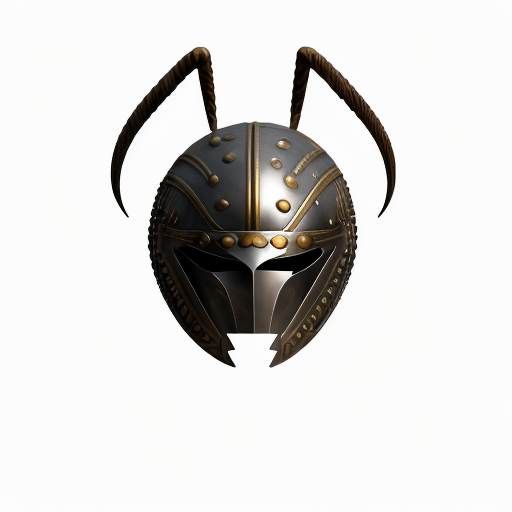

In [4]:
pilImage

success


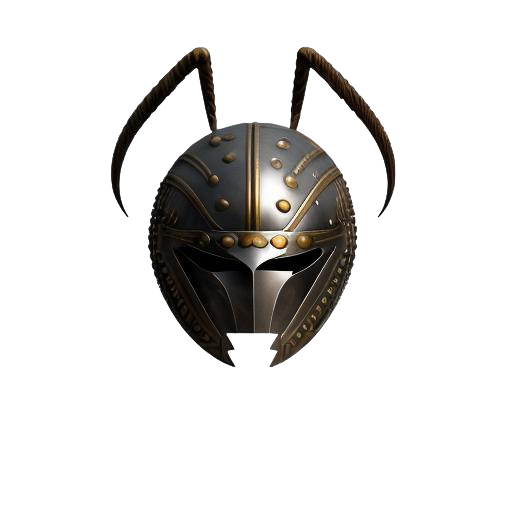

In [5]:
# pil image pilImage as bytes
image_file_object = io.BytesIO()
pilImage.save(image_file_object, format='JPEG')
image_file_object.seek(0)  # Go back to the start of the file object
image_bytes = image_file_object.read()  # Read the bytes from the file object
r = requests.post('https://clipdrop-api.co/remove-background/v1',
  files = {
    'image_file': ('car.jpg', image_bytes, 'image/jpeg'),
    },
  headers = { 'x-api-key': CLIPDROP_KEY}
)
if (r.ok):
    print("success")
    rembg_image = Image.open(io.BytesIO(r.content))
else:
  print(r.status_code, r.text) # e.g. 400 "Invalid image file"
rembg_image

In [6]:
urls = [
    "https://s3.amazonaws.com/esov-sdapi-args-images/original_sp.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/final_sp.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l1_chin.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_george.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_luke.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_satoshi.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_spart.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_sun.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_will.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_01.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_02.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_03.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_04.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_05.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_06.jpg",
]

original_sp = ["https://s3.amazonaws.com/esov-sdapi-args-images/original_sp.jpg"]
final_sp = ["https://s3.amazonaws.com/esov-sdapi-args-images/final_sp.png"]
l1_chin = ["https://s3.amazonaws.com/esov-sdapi-args-images/l1_chin.png"]
l3 = [
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_george.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_luke.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_satoshi.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_spart.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_sun.png",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l3_will.png",
]
l4_bg = [
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_01.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_02.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_03.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_04.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_05.jpg",
    "https://s3.amazonaws.com/esov-sdapi-args-images/l4_bg_06.jpg",
]

all_arrays = [original_sp, final_sp, l1_chin, l3, l4_bg]
for arr in all_arrays:
    for i in range(len(arr)):
        url = arr[i]
        imageBytes = requests.get(url).content
        pilImage = Image.open(BytesIO(imageBytes))
        arr[i] = pilImage

In [7]:
print(f"original_sp img size {original_sp[0].size}")
print(f"final_sp img size {final_sp[0].size}")
print(f"l1_chin img size {l1_chin[0].size}")
print(f"l3 img size {l3[0].size}")
print(f"l4_bg img size {l4_bg[0].size}")

original_sp img size (800, 800)
final_sp img size (800, 800)
l1_chin img size (800, 800)
l3 img size (800, 800)
l4_bg img size (800, 800)


In [8]:
rembg_image_resized = rembg_image.resize((800, 800))
random_bg = l4_bg[random.randint(0, len(l4_bg) - 1)]
random_bottom = l3[random.randint(0, len(l3) - 1)]

In [9]:
def add_outline(img):
    # Create a copy of the original image to work with
    original_image = img.copy()
    outlined_image = original_image.copy()

    # Apply a contour filter to create an outline
    outline_image = outlined_image.filter(ImageFilter.CONTOUR)

    # Convert the outline image to have an alpha channel
    outline_image.putalpha(255)

    # Create a blank image to hold the final result
    final_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))

    # Composite the original image onto the final image
    final_image.paste(original_image, (0, 0), original_image)

    # Composite the outline image onto the final image
    final_image.paste(outline_image, (0, 0), outline_image)

    # Save or display the result
    return final_image

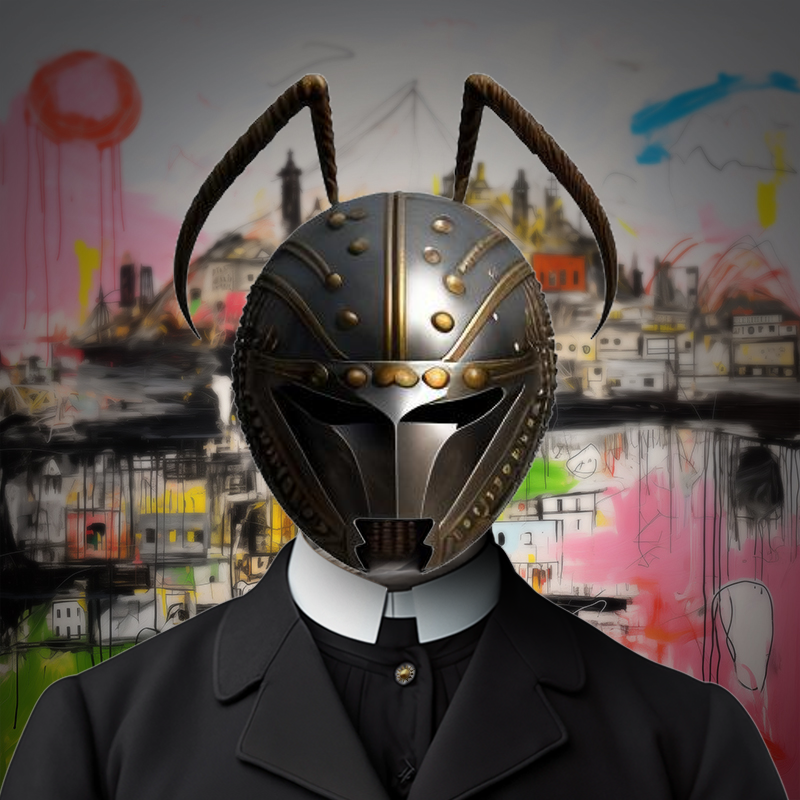

In [10]:
filteredImage = add_outline(rembg_image_resized)

base_image = Image.new('RGBA', random_bg.size, (0, 0, 0, 0))
base_image.paste(random_bg, (0, 0))
base_image.paste(random_bottom, (0, 0), random_bottom)
base_image.paste(rembg_image_resized, (0, 0), rembg_image_resized)
base_image.paste(l1_chin[0], (0, 0), l1_chin[0])
base_image

In [26]:
# Convert the base_image to a byte stream
byte_stream = BytesIO()
base_image.save(byte_stream, format='PNG')
byte_stream.seek(0)
buffer = byte_stream.getvalue()
reader = io.BytesIO(buffer)
base_image.save("output.png")

In [27]:
url = "https://api.nft.storage/upload"
headers = {
    "Authorization": f"Bearer {NFTSTORAGE_KEY}"
}
files = {
    "file": buffer
}
response = requests.post(url, headers=headers, files=files)
cid = response.json()['value']['cid']
print(cid)

bafybeiha3eodnb6bynqd6oaecjj5wpdwge265ykmj2pcttz3eutwsgoclu


In [17]:
# List of IPFS gateways
gateways = [
    # 'https://ipfs.io/ipfs/',
    # 'https://cloudflare-ipfs.com/ipfs/',
    'https://gateway.pinata.cloud/ipfs/',
    'https://ipfs.infura.io/ipfs/',
    'https://gateway.ipfs.io/ipfs/'
]

# Try each gateway until one works
for gateway in gateways:
    try:
        print(f"Trying gateway: {gateway}")
        url = f"{gateway}{cid}"
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status() 
        # try parse and pring json from response.raw
        # img = Image.open(io.BytesIO(response.content))
        utf_string = response.content.decode('utf-8')
        print(url)
        # print(utf_string)
        # json_obj = json.loads(utf_string)
        # print(json_obj)
        
        
        break
    except requests.RequestException:
        continue

# Display the html

Trying gateway: https://gateway.pinata.cloud/ipfs/
https://gateway.pinata.cloud/ipfs/bafybeiha3eodnb6bynqd6oaecjj5wpdwge265ykmj2pcttz3eutwsgoclu


In [30]:
json_data = {
    "name": "valiAnt",
    "description": "valiAnts are the core volunteer participants in the original Riddle of the Crown. They are the few, the brave, they are the gladiators, they are the Revolt!",
    "image_cid": cid,
    "attributes": [
      {
        "trait_type": "Prompt",
        "value": "Gladiator"
      },
      {
        "trait_type": "Seed",
        "value": "306620667"
      },
      {
        "trait_type": "Chin guard",
        "value": "Gold Dragon"
      },
      {
        "trait_type": "Body Type",
        "value": "Minuteman"
      },
      {
        "trait_type": "Body Color 1",
        "value": "Blue"
      },
      {
        "trait_type": "Body Color 2",
        "value": "Green"
      },
      {
        "trait_type": "Background",
        "value": "Prodigy"
      },
      {
        "trait_type":"MintDate",
        "value": "2024-03-12"
      }
    ]
  }

In [31]:
json_utf8_buffer = json.dumps(json_data).encode('utf-8')
io_buffer = io.BytesIO(json_utf8_buffer)
io_buffer.seek(0)
buffer = io_buffer.getvalue()
# print(json_utf8_buffer)
files = {
    "file": buffer
}
response = requests.post(url, headers=headers, files=files)
# print(response.text)
cid = response.json()['value']['cid']
print(cid)

bafybeiceupgjeqtynw5r5dufr4n4w7ryfho56rg4v4rqo34gjy32radccu
